In [173]:
%matplotlib notebook
import torch.nn as nn
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import webdataset as wds
import glob
from torchvision import transforms
import imgaug.augmenters as iaa
from webdataset.handlers import ignore_and_continue
from PIL import Image
import io
from pytorch3d.transforms import euler_angles_to_matrix
from pytorch3d.transforms import matrix_to_euler_angles
from mpl_toolkits.mplot3d import axes3d 
from copy import deepcopy

In [174]:
iaa_valid = iaa.Resize((368, 368))
def parse_euler(x, joint_indices):
    x = x.decode("utf-8").split(",") 
    x = np.array(x).astype(float).reshape(-1,6)[joint_indices]
    return x
    
    
def transform3D(x, joint_indices):
    x = x.decode("utf-8").split(",")
    x = np.array(x).astype(float).reshape(-1,3)[joint_indices]
    
    return x.reshape(-1)
 

def pil_decode(data, augment=False):
    img = np.array(Image.open(io.BytesIO(data)))
    if augment:
        img = seq(images=[img])[0] 
    else:
        img = iaa_valid(images=[img])[0]
    img = Image.fromarray(img)

    return img
    

def decode_train(sample):
    return decode_sample(sample)
preproc = transforms.Compose([
    transforms.ToTensor(),
])
def decode_sample(sample): 
    print(sample["__key__"])
    # hip, spine1, spine2, thorax
    # right shoulder, right arm, right forearm, right hand
    # left shoulder, left arm, left forearm, left hand 
    
    # https://github.com/facebookresearch/xR-EgoPose/blob/main/utils/config.py
    # kinematic tree
    joint_indices = [0, 2, 3, 4, 13, 14, 15, 16,21, 22, 23, 24]
    pose_img = preproc(pil_decode(sample["pose_image.png"]))
    pose_3dp = transform3D(sample["pose_3dp.csv"], joint_indices)
    rot_3dp = parse_euler(sample["pose_3da_rot.csv"], joint_indices)

    return dict(
        image=pose_img,
        pose=pose_3dp,
        rotation=rot_3dp
    )


In [175]:
test_path = "/egopose-data/web-datasets/xrEgoPose_trainset_male_004_a_a_env_001_000.tar"
test_url = glob.glob(test_path)
ds_test = wds.WebDataset(test_url).map(decode_train).to_tuple("image", "pose", "rotation")
test_loader = torch.utils.data.DataLoader(ds_test, num_workers=0, batch_size=1)

In [176]:
def swap(translation, seq="XYZ"):
    order = {"X":0, "Y":1, "Z":2}
    new_order = [translation[order[seq[0]]], translation[order[seq[1]]], translation[order[seq[2]]] ]
    return np.array(new_order)

def test_forward(rot_trans, order="XYZ"): #
    matrices = []
    offsets = []
    positions = [np.zeros((3,))]
    for ind, rot_tran in enumerate(rot_trans):
        angles = rot_tran[:3] # first 3 values are euler angles (xyz)

#         if ind == 4:
# #             tmp = deepcopy(angles[0])
# #             angles[0] = angles[1]
# #             angles[1] = tmp
#             angles[1] = -20 #-15
#             angles[2] += -50
#             angles[0] = 100#10
                
            
        print(ind,"Rotation Angles:", (angles).tolist())
        trans = rot_tran[3:] # last three values are translations
#         trans = torch.zeros(trans.shape)
#         trans[2] = 11 # z
#         if ind == 4: # goes in X 
#             trans[0] += -10
#         if ind > 4:
#             trans[0] = 15

        angles = np.radians(angles)
#         if ind > 4:
#             angles = torch.zeros(angles.shape)
        rot_matrix = euler_angles_to_matrix(angles, order) # 3x3 rotation matrix
        matrices.append(rot_matrix)
        offsets.append(trans)
        
    for i in range(1, len(matrices)):
        position = np.matmul(offsets[i], matrices[i-1])
        positions.append(position + positions[i-1])
        matrices[i] = np.matmul(matrices[i], matrices[i-1]) 
        

    return positions

def plot(positions1, positions2):
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim([-75, 75])
    ax.set_ylim([-75, 75])
    ax.set_zlim([-75, 75])
    
    for position, color in zip([positions, positions2], ("red", "green")):
        first = deepcopy(position[0])
        for ind, pos in enumerate(position):
#             pos -= first # subtract first joint
            ax.scatter(pos[0], pos[1], pos[2], color=color)

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

    plt.show()
    

xrEgoPose_trainset_male_004_a_a_env_001_000/male_004_a_a_000001
0 GT Pose:  [7.020534290976554, -20.83492368528206, 12.752965843404922]
1 GT Pose:  [22.533424451641228, -20.290509280572152, 17.276905931192914]
2 GT Pose:  [44.4282998481714, -20.150332449518075, 17.244735105368363]
3 GT Pose:  [74.58042230440958, -19.91069245793932, 17.165749236744716]


0 Rotation Angles: [20.05230477987628, 85.6120124927215, -86.36723734458778]
1 Rotation Angles: [-0.4775219566878915, 84.9378084649646, -90.49963181478338]
2 Rotation Angles: [0.5116895562047666, 84.78893493862286, -89.44887566822369]
3 Rotation Angles: [0.5892669348973023, 84.70810888070346, -89.37671125957007]


0 FK pose [0.0, 0.0, 0.0]
1 FK pose [-131.84955920885665, 66.75232867839614, 19.91318635908322]
2 FK pose [-158.30714609921708, 17.18950123495253, -123.68999570649626]
3 FK pose [-21.522641648481738, 108.10526258655283, -146.15595204872412]


<IPython.core.display.Javascript object>


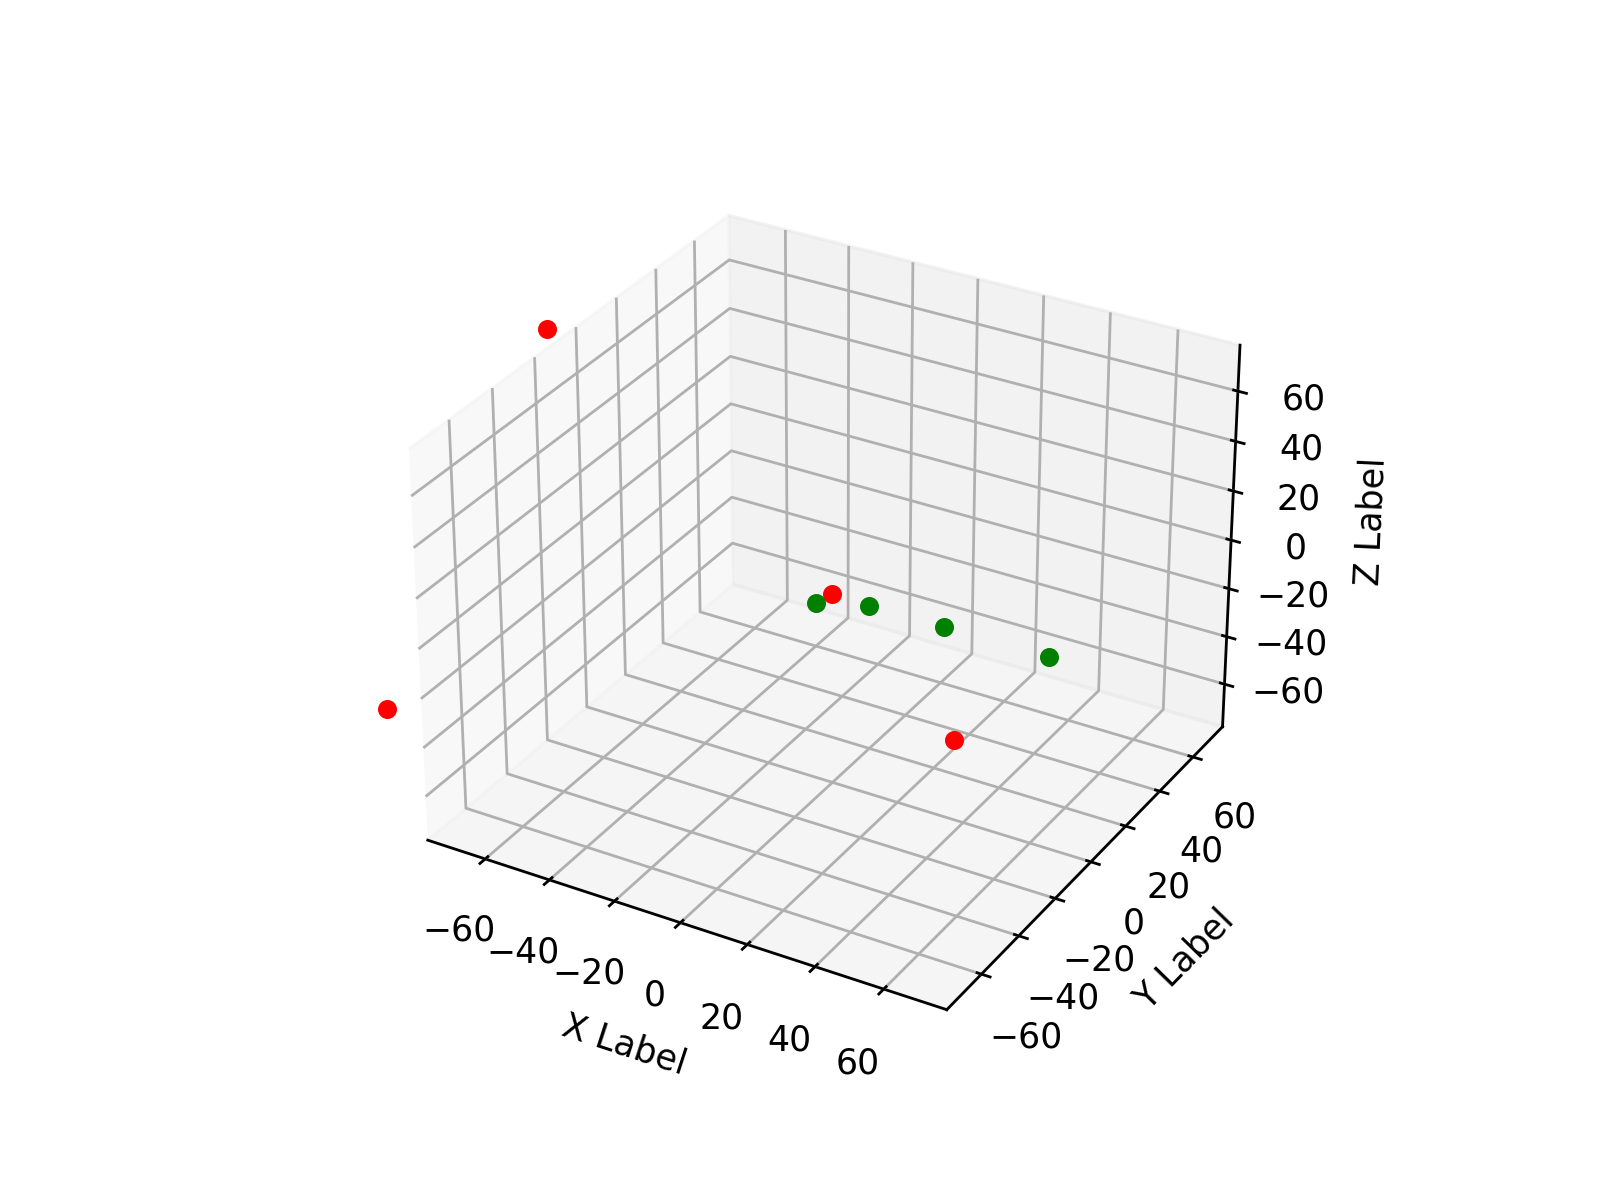

In [178]:
for i, sample in enumerate(test_loader):
    joint_angles = sample[2][0][[8,9,10,11]] # Translatoins and Angles 
    gt_pose = sample[1][0].reshape(-1,3)[[8,9,10,11]] # gt 3d pose

#     joint_angles = sample[2][0][[0,1,2,3, 8]]
#     joint_angles[0][2] = 0
#     joint_angles[0][1] = 180
#     joint_angles[0][0] = 0
#     gt_pose = sample[1][0].reshape(-1,3)[[0,1,2,3, 8]]
#     first = deepcopy(gt_pose[0])
    for ind, point in enumerate(gt_pose):
        print(ind, "GT Pose: ", (point).tolist())
    print("\n")

    positions = test_forward(joint_angles, "XYZ") # hip, spine(3), shoulder, arm, forearm, hand (right)
    print("\n")
    
    for ind, position in enumerate(positions):
        print(ind, "FK pose", position.tolist())
    plot(positions, gt_pose)

    break

    

   

In [ ]:
def test_angles(angles):
    orig_angles = angles
    print(orig_angles)
    angles = np.radians(angles)
    rot_matrix = euler_angles_to_matrix(angles, "XYZ")
    angles = matrix_to_euler_angles(rot_matrix, "XYZ")
    angles = np.degrees(angles)
    print(angles)
    print("\n")
